In [16]:
! pip install mplcyberpunk

Defaulting to user installation because normal site-packages is not writeable


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
import xgboost as xgb
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
plt.style.use('cyberpunk')

In [68]:
df = pd.read_csv("D:\Project Resource\Time Series\data\PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

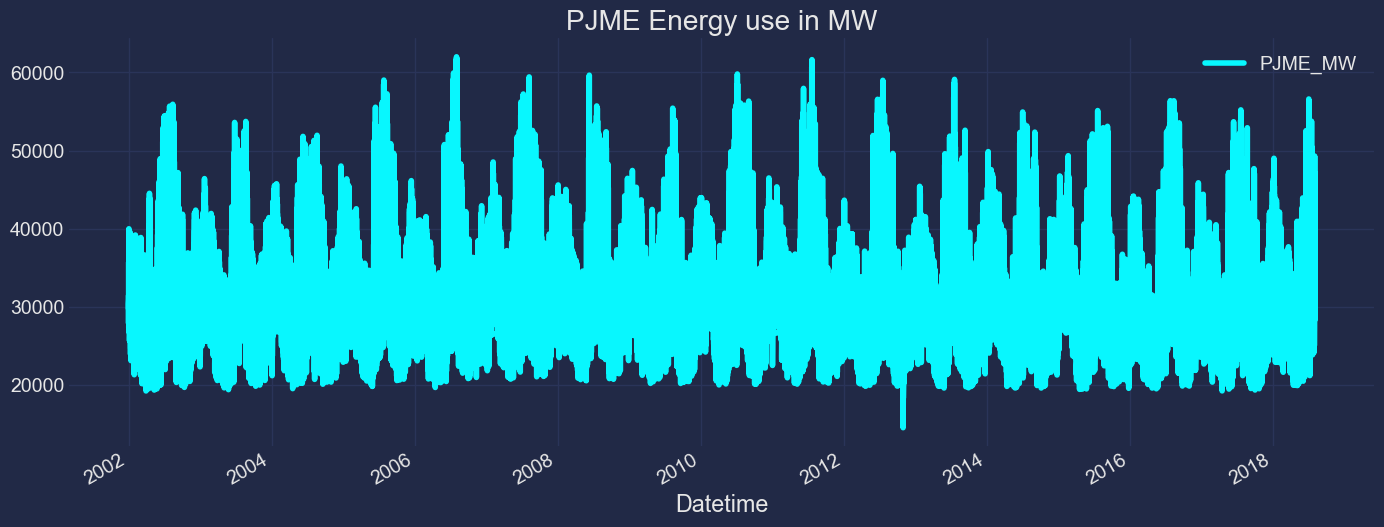

In [69]:
df.plot(style='-', 
        figsize=(15,6),
        title="PJME Energy use in MW" )
plt.show()

In [70]:
## Train test Split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

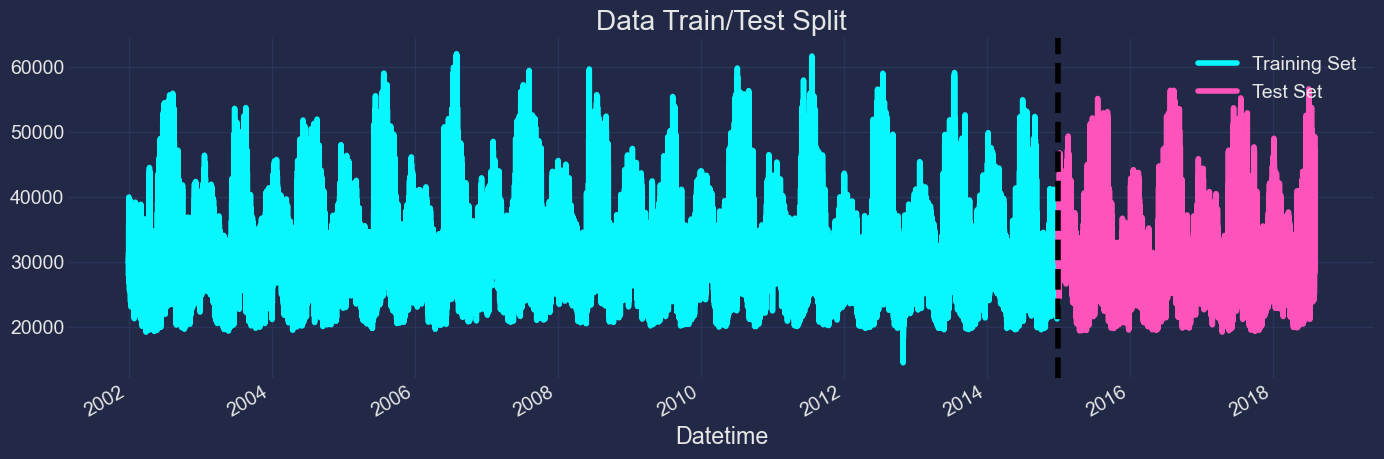

In [71]:
fig, ax  = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

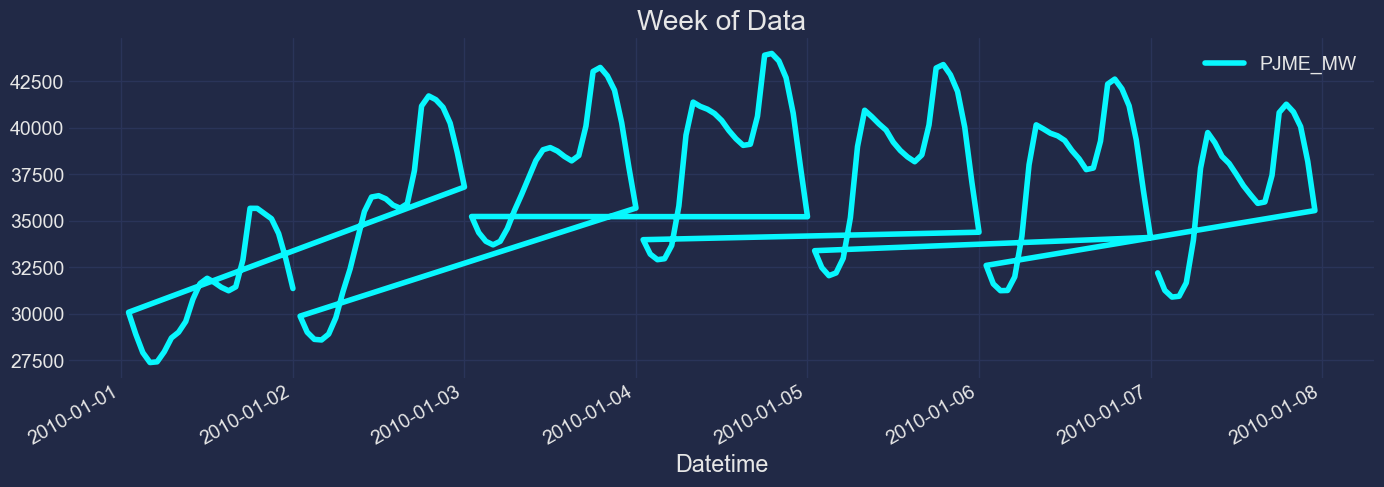

In [77]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]\
    .plot(figsize=(15,5),kind='line', title='Week of Data')
plt.show()

## feature Creation 

In [82]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df['hour'] = df.index.hour
    df['daysofweek'] = df.index.day_of_week
    df['quater'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df
df = create_features(df)

## Visualization our Features / Target Relationship

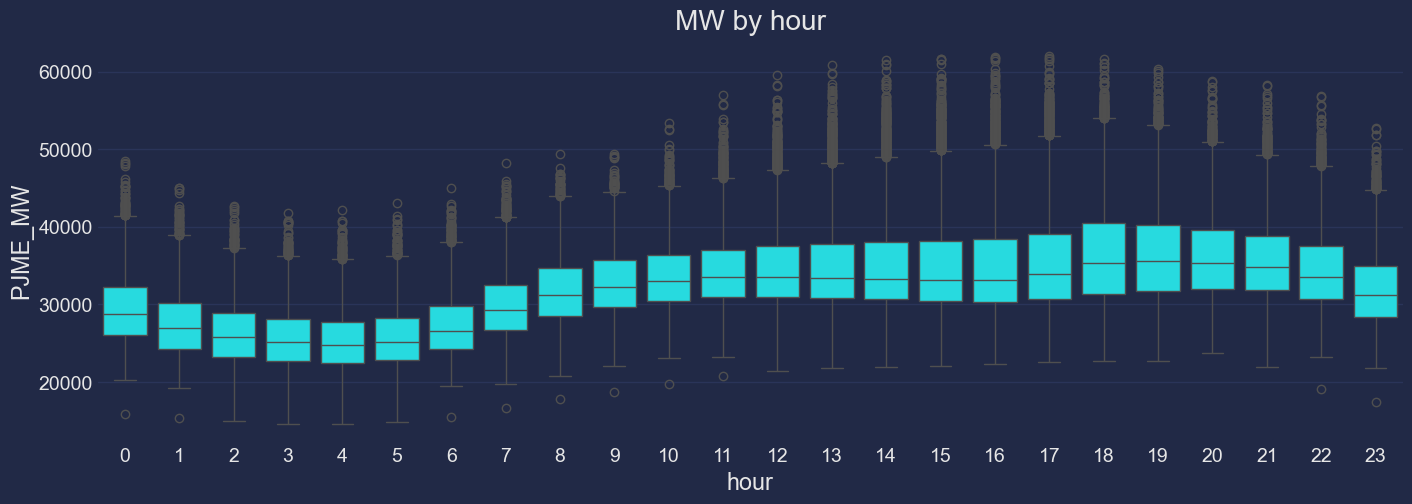

In [83]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

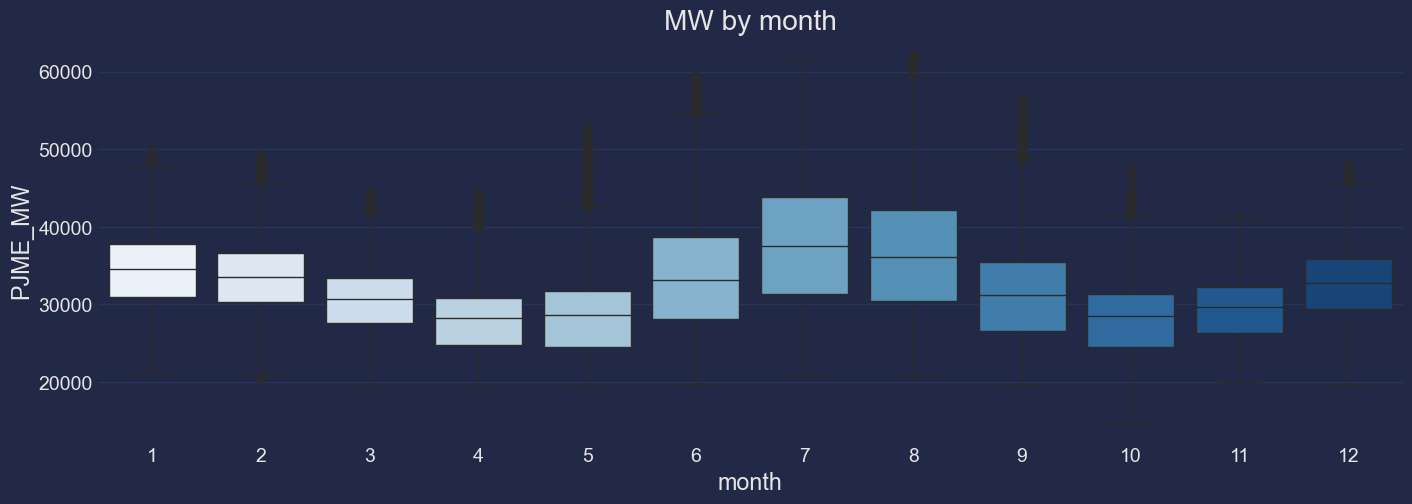

In [85]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by month')
plt.show()

## Creating Model

In [88]:
train  = create_features(train)
test =  create_features(test)

In [89]:
df.columns

Index(['PJME_MW', 'hour', 'daysofweek', 'quater', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [90]:
features = [ 'hour', 'daysofweek', 'quater', 'month', 'year','dayofyear']
target = ['PJME_MW']

In [91]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [95]:
reg = xgb.XGBRegressor(n_estimator = 1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train,y_train),(X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[99]	validation_0-rmse:3923.68714	validation_1-rmse:4321.32510


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=1000, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

# Feature Importance

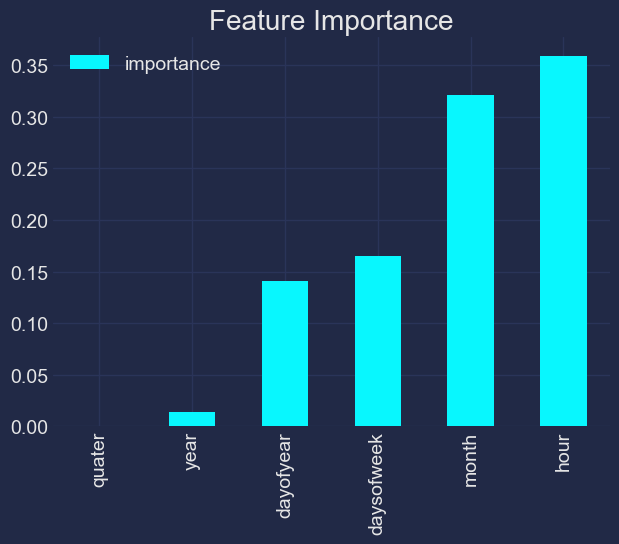

In [100]:
fi = pd.DataFrame(reg.feature_importances_, 
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='bar', title='Feature Importance')
plt.show()

# Forcast On test model

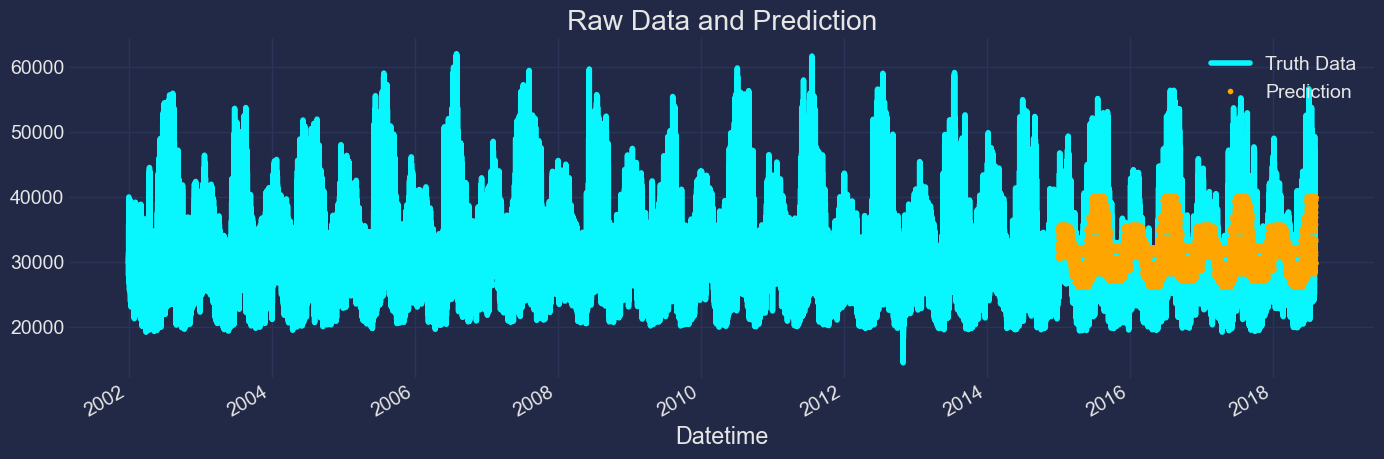

In [ ]:


test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


fig, ax = plt.subplots(figsize=(15, 5)) 
df[['PJME_MW']].plot(ax=ax)
df['prediction'].plot(ax=ax, style='.', color='orange')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()


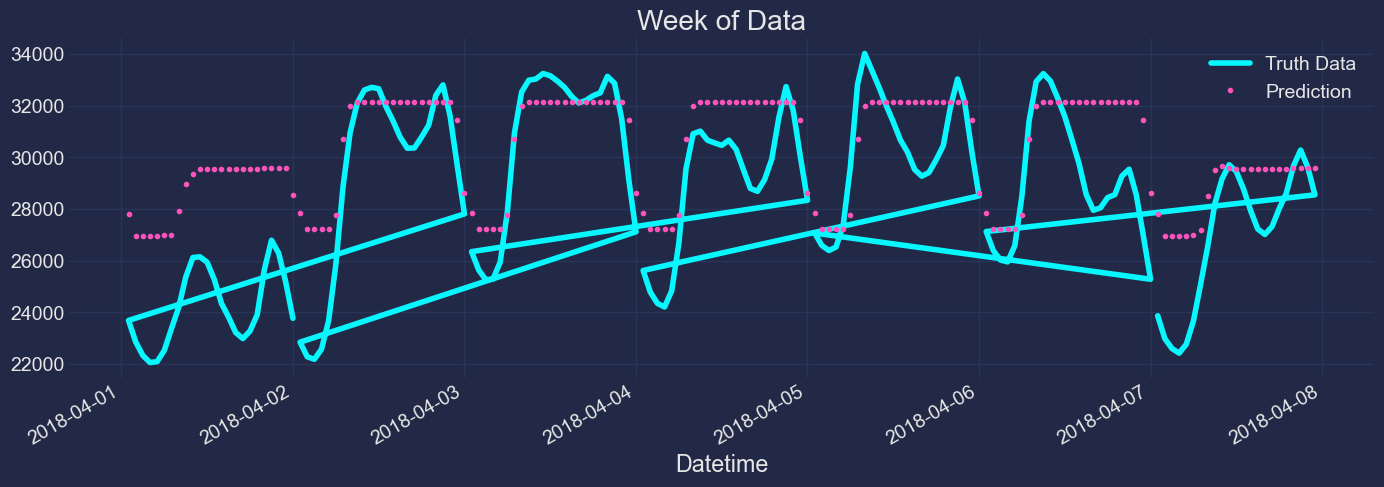

In [110]:
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
    .plot(figsize=(15,5), title='Week of Data')

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [113]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 4321.33
